# Estimation of linear filter using analytical solution
## Comparison of the solution using the Normal Equation, PC regression and Ridge.
### In this exercise you will estimate a visual spatio-temporal receptive field from a model neuron driven by a natural movie. 

In [1]:
# Load up the depencies

import numpy as np
import mne
import os.path as op
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
plt.ion()

In [2]:
# Set up the paths for the data
path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'
path_data = op.join(path_base, 'data')
path_stims = op.join(path_data, 'all_stims')


## Load a 20000 (time) x 10 x 10  natural movie and preprocess

In [4]:
# Load up the movie.  Notice the size of the movie.
data = loadmat(op.join(path_data, 'mov.mat'))
movie_all = data['mov']
movie_all = movie_all.transpose([2, 0, 1])
print(movie_all.shape)

(20000, 10, 10)


In [6]:
# Subtract the mean to obtain a zeroed stimulus
mean_stim = movie_all.mean()
movie_all = movie_all - mean_stim
fitPoints = 15000

# Part of the movie for fitting
movie = movie_all[0:fitPoints]

# Part of the movie for testing
movie_test = movie_all[fitPoints:]

## Exercise 1  
### Using subplot plot the first 10 images.  Then plot images 10, 100, 1000, 10000.  
### Using these pictures comment on the temporal and spatial correlations.
### Plot them using a grey map and with the correct aspect ratio. Also remove the two axes.

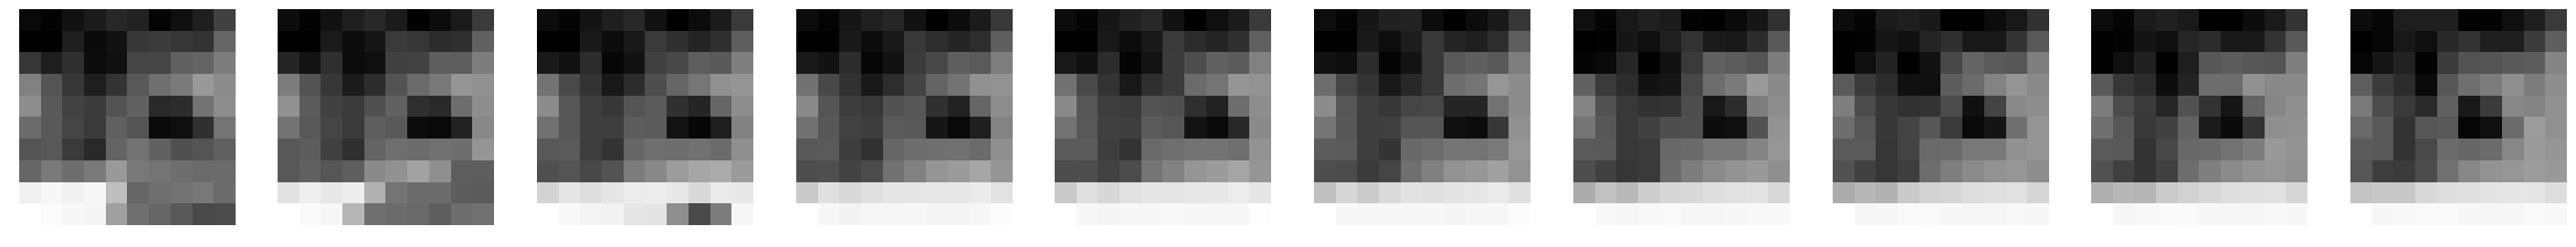

In [7]:
# Solution.  First 10 Images.
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for ii in range(10):
    ax[ii].imshow(movie[ii], cmap='Greys_r', aspect='equal') # Grey reverse to match matlab. 
    ax[ii].set_axis_off()

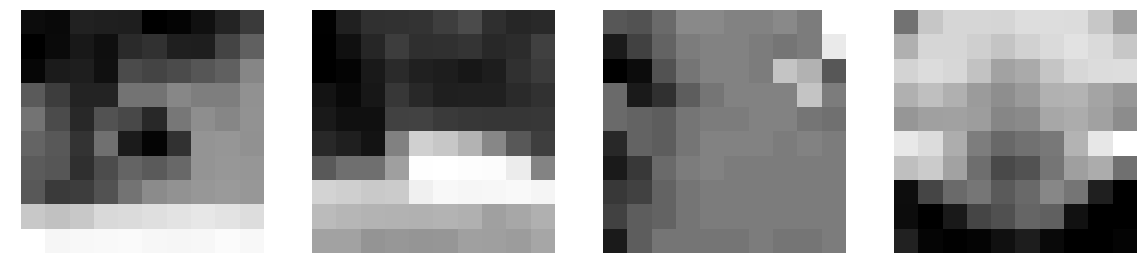

In [8]:
# Solution.  Images 10, 100, 1000, 10000.
fig, ax = plt.subplots(1, 4, figsize=(4*5, 5))
for ii in range(4):
    ax[ii].imshow(movie[int(10**(ii+1))], cmap='Greys_r', aspect='equal')
    ax[ii].set_axis_off()

## Model Neuron.
### We are going to create responses for model simple cell in V1 with a STRF that is a 2D Gabor filter.


In [9]:
# Generating a 2d Gabor 

# Some useful functions
from skimage.filters import gabor, gabor_kernel
from scipy import ndimage as ndi

In [10]:
# We are only going to use on gabor but here is code that you can use
# to generate a filter bank. We are calling the filters kernels.

kernels = []
theta = 0       # Orientation of the Gabor in degrees
theta = (theta/180.0) * np.pi # In radiants.
sigma = 1       # Bandwidth
frequency = 0.4  # Spatial frequency in pixels.
offset = np.pi/8

kernel = np.real(gabor_kernel(frequency, theta=theta, bandwidth=sigma, offset = offset))
kernel = kernel[:10, :10]
kernels.append(kernel)

kernel = np.imag(gabor_kernel(frequency, theta=theta, bandwidth=sigma, offset = offset))
kernel = kernel[:10, :10]
kernels.append(kernel)



## Exercise 2  
### We have generated two Gabors with sine and cosine harmonic. Plot them using grey scale.  


(10, 10)
(10, 10)


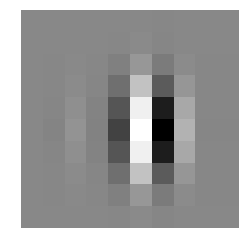

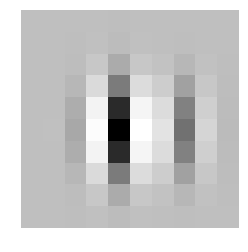

In [11]:
# Solution
for kernel in kernels:
    print(kernel.shape)
    fig, ax = plt.subplots()
    ax.imshow(kernel, aspect='equal', cmap='Greys_r')
    ax.set_axis_off()

## Generation of the model neuron response.
### The model response is obtained by convolving the Gabor filter with the stimulus and adding Gaussian noise to get a response with an SNR of 0.5

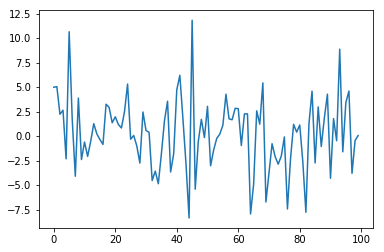

In [12]:
# Convolve the movie with the filter
kernel = kernels[0]
movie_vec = movie.reshape([movie.shape[0], -1])
resp = np.dot(movie_vec, kernel.ravel())     # np.dot performs matrix multiplication

# Add noise to the response
resp_pow = np.var(resp)
SNR = 0.5
resp = resp + np.sqrt(resp_pow / SNR) * np.random.randn(len(resp), *resp.shape[1:])

# Plot the firt 100 time points of the response
fig, axs = plt.subplots()
axs.plot(resp[0:100])

# Recovering the filter.

## Exercise 3.
### Find the cross-correlation between the stimulus and the response (Note: In this case there is no time component).  Plot it and compare it to the original filter.  This is also the spike-triggered average or STA.
### Find the stimulus auto-correlation and visualize it. Explain what you see.

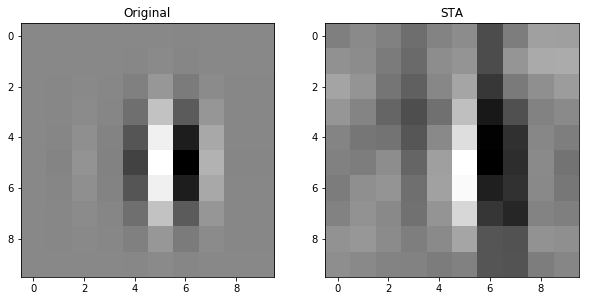

In [13]:
# Solution for the cross-correlation
cross_stim_response = np.dot(movie_vec.T, resp) / movie_vec.shape[0]

# Plotting it and comparing to the original kernel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, out, label in zip(axs, [kernel, cross_stim_response.reshape([10, 10])], ['Original', 'STA']):
    ax.imshow(out, 'Greys_r')
    ax.set(title=label)

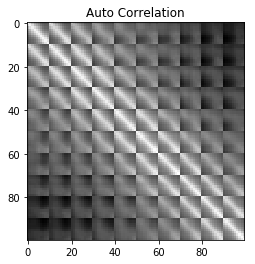

In [14]:
# Solution for the stimulus auto-correlation

mean_auto_corr = np.zeros([100, 100]);

# Calculating the sum of cross-products for each point in time.
for it in range(resp.shape[0]):
    this_vec = movie_vec[it][:, np.newaxis]
    auto_corr = np.dot(this_vec, this_vec.T)
    mean_auto_corr += auto_corr
    
# Dividing by the number of time points.
mean_auto_corr /= resp.shape[0]

# Plot the stimulus auto-correlation
fig, ax = plt.subplots()
ax.imshow(mean_auto_corr, cmap='Greys_r')
ax.set(title='Auto Correlation')

## Exercise 4. 
### Estimate the filter using the normal equation: Cross-correlation/Auto-correlation
### Hints: np.dot() is matrix multiplication and np.linalg.inv() can be used to obtain the inverse of the stimulus Auto-correlation.
### Note in Python 3, you can use @ for np.dot()


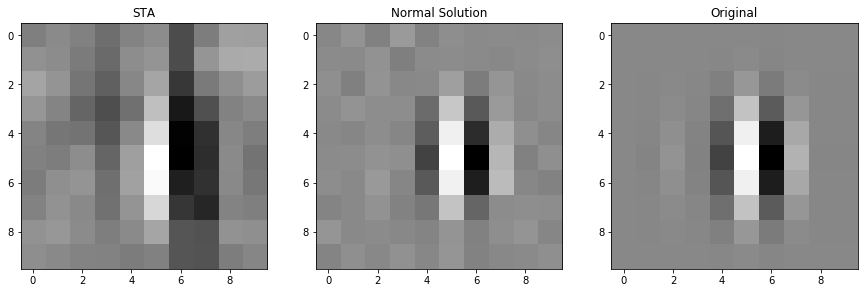

In [15]:
# Solution.

# The normal equation in one line. The reshape puts it back in the 10x10 dimensions.
myfilter = np.dot(np.linalg.inv(mean_auto_corr), cross_stim_response).reshape([10, 10])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = ['STA', 'Normal Solution', 'Original']
for ax, im, lab in zip(axs, [cross_stim_response.reshape([10, 10]), myfilter, kernel], labels):
    ax.imshow(im, cmap='Greys_r')
    ax.set(title=lab)

## Exercise 5.  Obtain the Filter using PCA regression. Try the projection in 10, 20, 50, 100 eigen dimensions. 
### Hints: You can perform an svd on a auto-correlation matrix to get the eigenvectors: np.linalg.svd()
### Alternatively you can use the eigenvalue decomposition: np.linalg.eig()

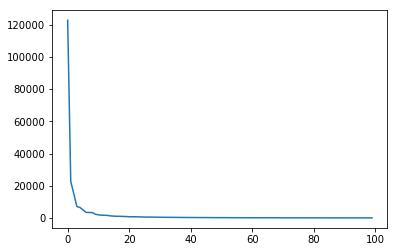

In [16]:
# Solution

# Eigen decompostion of auto-corr and plotting the eigenvalues.
u, s, v = np.linalg.svd(mean_auto_corr)
fig, ax = plt.subplots()
ax.plot(s);

In [17]:
# Obtain filters by calculating the filter in subspaces of 10, 20, 50 and 100.
subspaces = [10, 20, 50, 100]
out_filters = {}
for subspace in subspaces:
    s_i = s.copy()
    s_i = 1. / s_i
    s_i[subspace:] = 0
    s_diag = np.diag(s_i)
    out_filters[subspace] = np.dot(u, np.dot(s_diag , np.dot(v, cross_stim_response) ) )

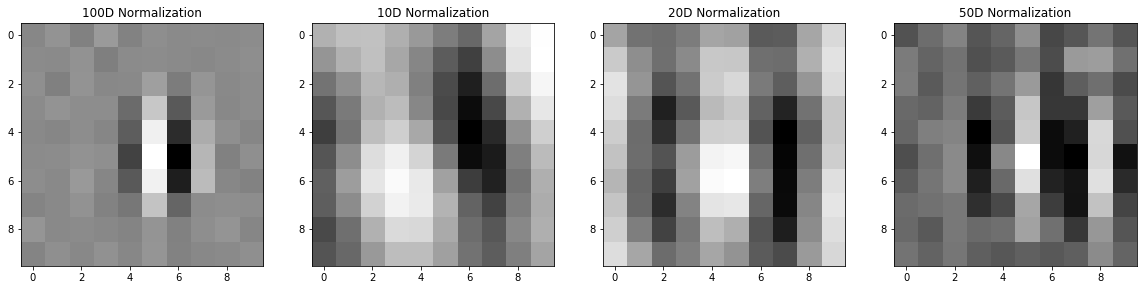

In [18]:
# Plot the results
n_plots = len(subspaces)
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for ax, (key, val) in zip(axs, out_filters.items()):
    ax.imshow(val.reshape([10, 10]), cmap='Greys_r')
    ax.set(title='{}D Normalization'.format(key))

In [19]:
# Solution using eig
d, v_eigen = np.linalg.eig(mean_auto_corr)

In [20]:
out_filters_eig = {}
for subspace in subspaces:
    d_i = d.copy()
    d_i = 1. / d_i
    d_i[subspace:] = 0
    d_diag = np.diag(d_i)
    out_filters_eig[subspace] = np.dot(v_eigen, np.dot(d_diag, np.dot(v_eigen.T, cross_stim_response) ) )

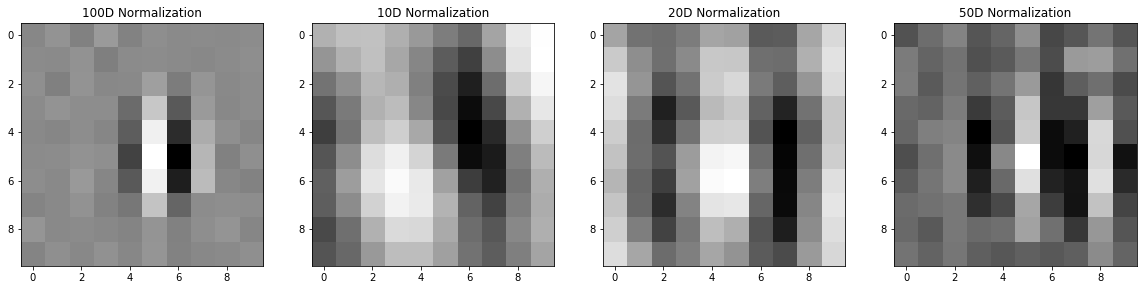

In [21]:
n_plots = len(subspaces)
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for ax, (key, val) in zip(axs, out_filters_eig.items()):
    ax.imshow(val.reshape([10, 10]), cmap='Greys_r')
    ax.set(title='{}D Normalization'.format(key))

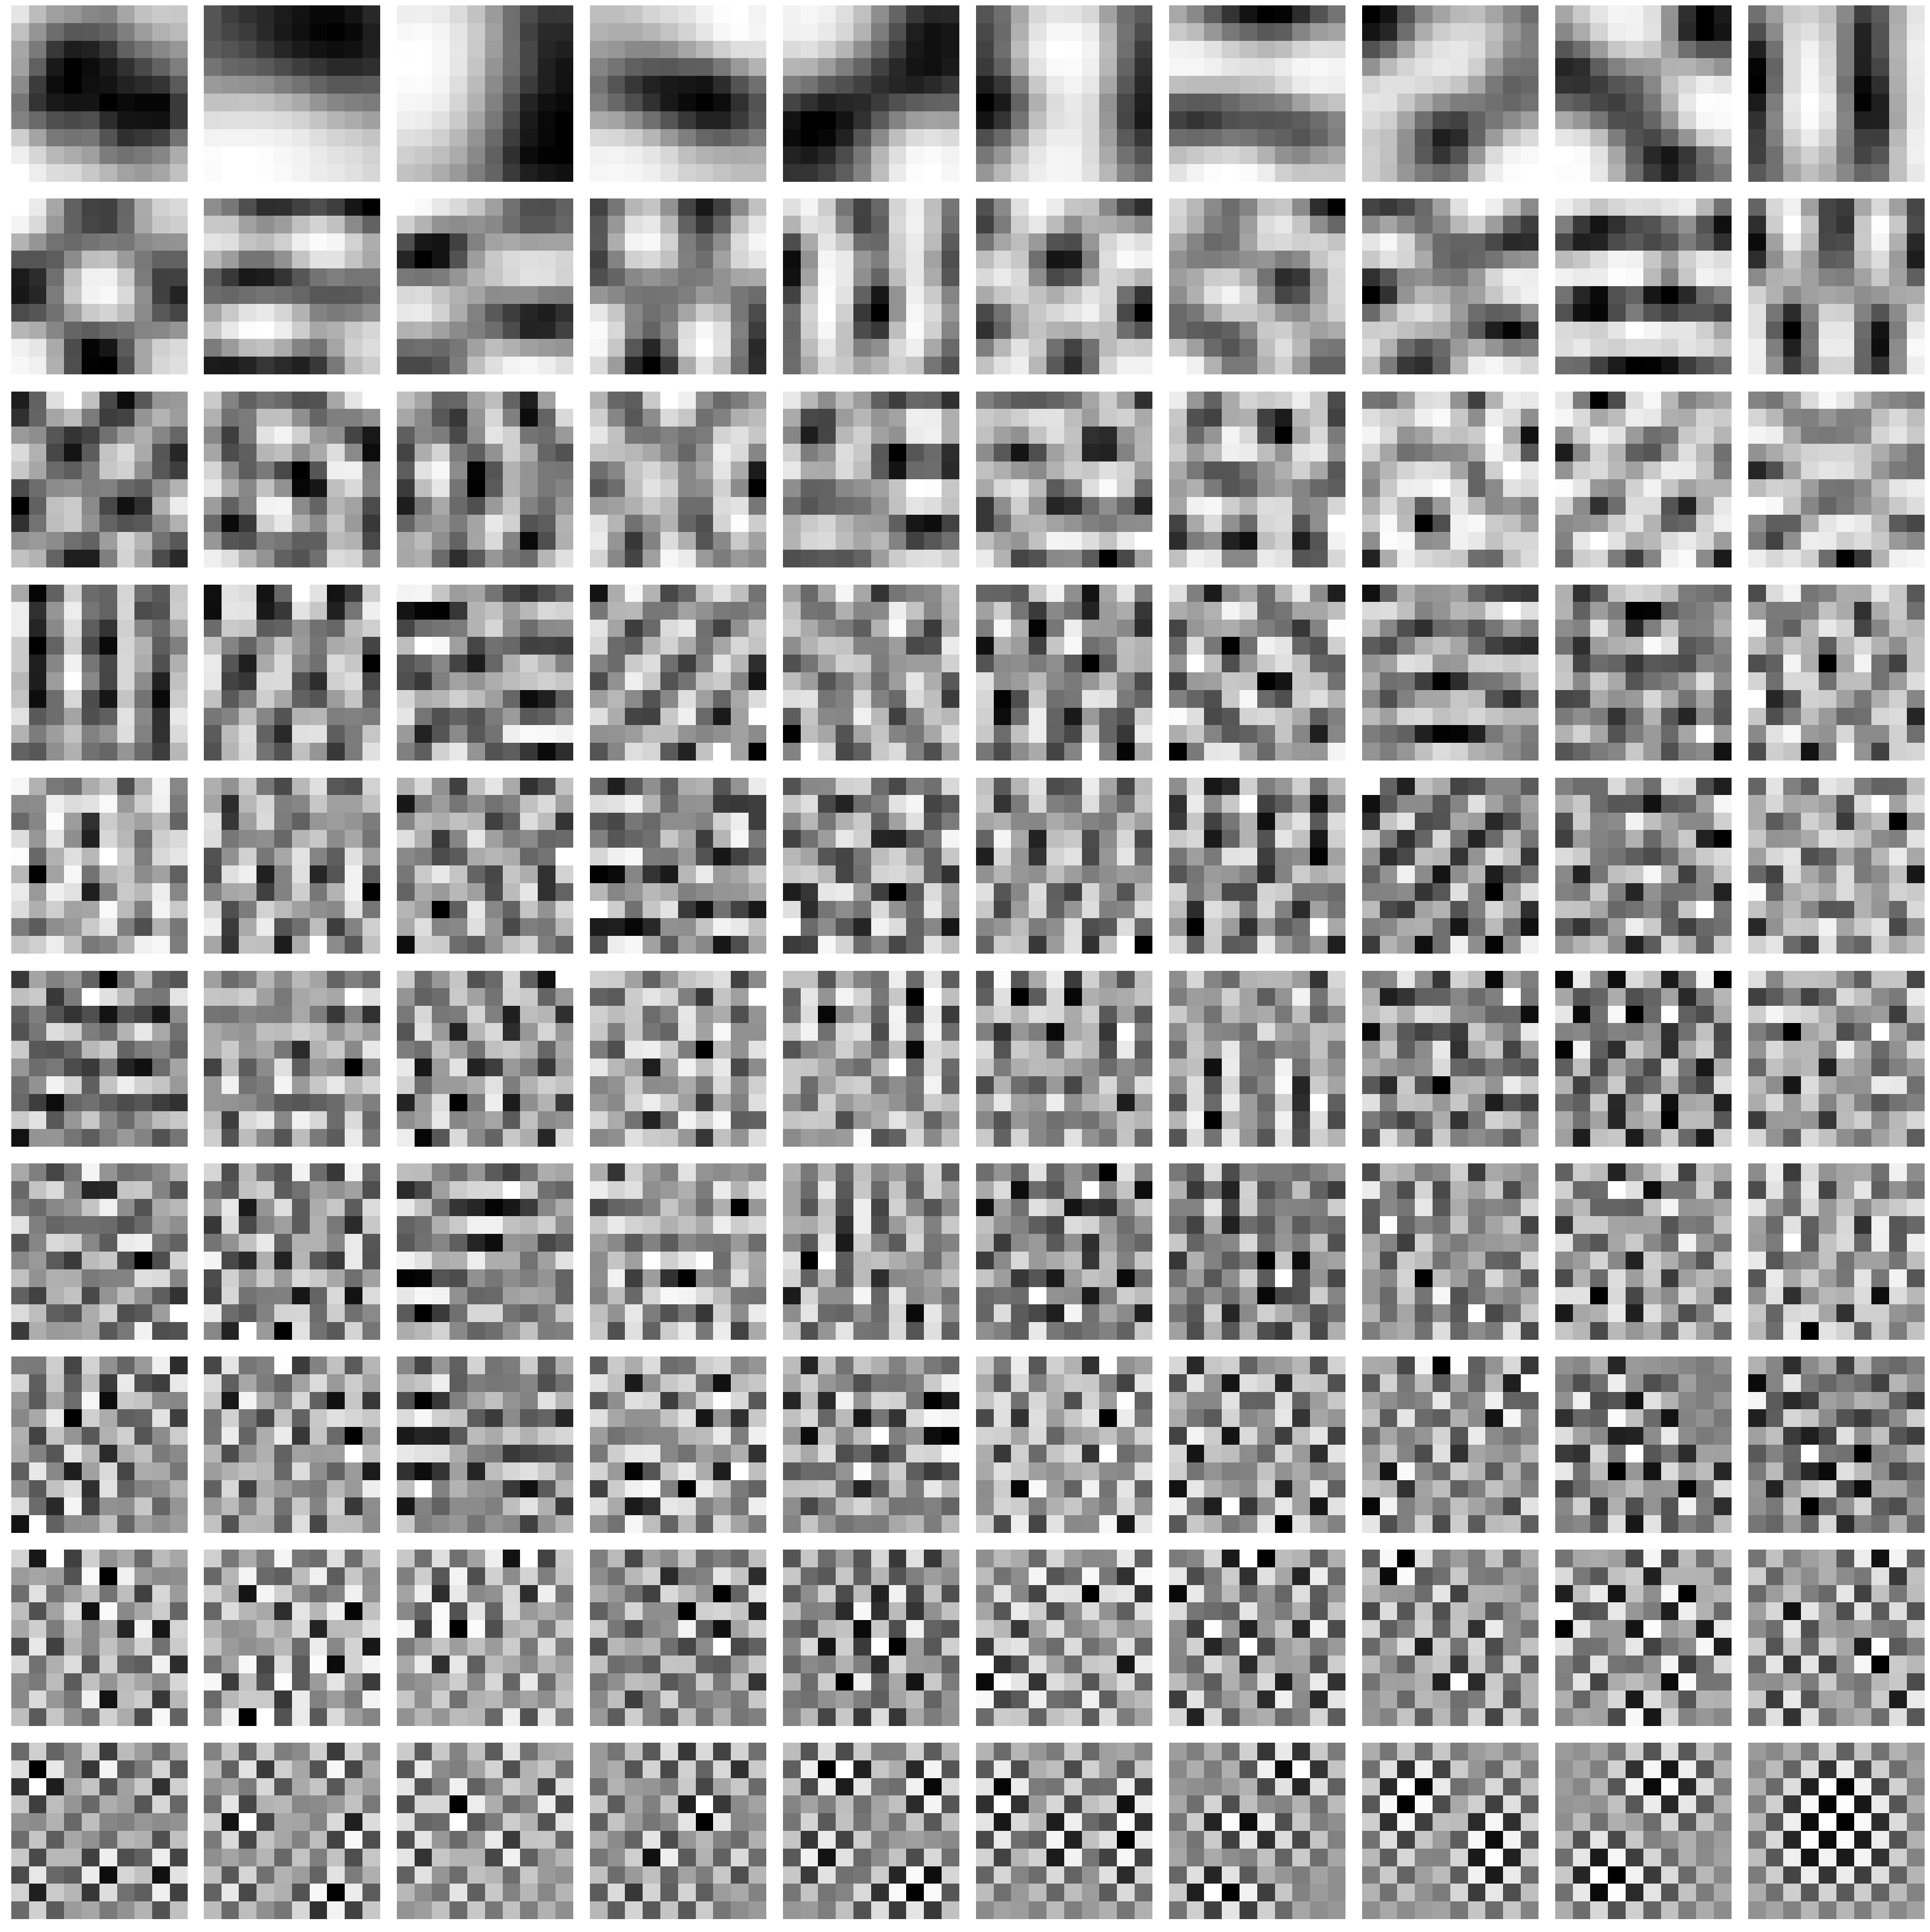

In [22]:
# Let's plot all 100 eigenvectors of our natual movie.

n_row = int(np.ceil(np.sqrt(u.shape[0])))
fig, axs = plt.subplots(n_row, n_row, figsize=(n_row * 5, n_row * 5))
for ax, row in zip(axs.ravel(), u.T):
    ax.imshow(row.reshape([10, 10]), cmap='Greys_r')
    ax.set_axis_off()
plt.tight_layout()

## Excercise 6 (Optional).  Perform the same calculation in the Fourier Domain.  
### In the Fourier domain the matrix division becomes a scalar division between two complex numbers. 
### This is a form of regularization as it assumes stationary second order statistics.

### Instructions: First calculate the Fourier Transform of the cross-correlation and auto correlation function. You should do this calculation in the 10x10 space and for the auto correlation, you can either reshape and average the 100x100 auto-correlation function (averaring the block diagonals) or recalculate the power spectrum of the image. You can then divide the cross-correlation by the auto-correlation in the Fourier domain. Finally take the inverse FFT to get back the filter. Did it give exactly the same result?

In [24]:
# Solution the auto correlation in the Fourier domain.

# FOurier Transform of Stimulus.
stim_pow = np.zeros(movie[0].shape)
for it in range(movie.shape[0]):
    stim_fft = np.fft.fft2(movie[it]);
    stim_pow = stim_pow + (stim_fft * np.conj(stim_fft))

stim_pow /= movie[0].shape[0]

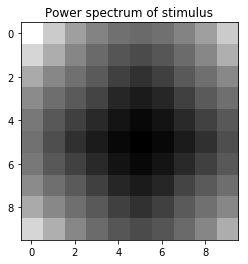

In [25]:
# Stimulus power
fig, ax = plt.subplots()
ax.imshow(10*np.log10(np.real(stim_pow)), cmap='Greys_r')
ax.set(title='Power spectrum of stimulus')

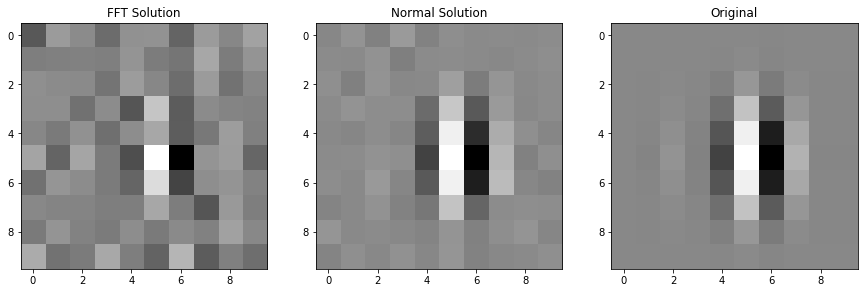

In [26]:
# FFT of cross-correlation.
sr_fft = np.fft.fft2(cross_stim_response.reshape([10, 10]))

# Normal equation in Fourier domain.
filter_fft = np.real(np.fft.ifft2(sr_fft/stim_pow))

# Plot the results.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = ['FFT Solution', 'Normal Solution', 'Original']
for ax, im, lab in zip(axs, [filter_fft, myfilter, kernel], labels):
    ax.imshow(im, cmap='Greys_r')
    ax.set(title=lab)


## Exercise 7. Calculate the Ridge Solution.
### Hint. Reuse the PCA regression code using values for lamba (the ridge parameter) of 0, 100, 1000 and 10000.

In [30]:
# Solution

# The lambda values
lvalues = [0, 100, 1000, 10000]

# Solution using eig (repeating just in case)
d, v_eigen = np.linalg.eig(mean_auto_corr)

# Calculate fiter for each value
out_filters_ridge = {}
for l in lvalues:
    d_i = d.copy()
    d_i = 1. / (d_i+l)
    d_diag = np.diag(d_i)
    out_filters_ridge[l] = np.dot(v_eigen, np.dot(d_diag, np.dot(v_eigen.T, cross_stim_response) ) )
    

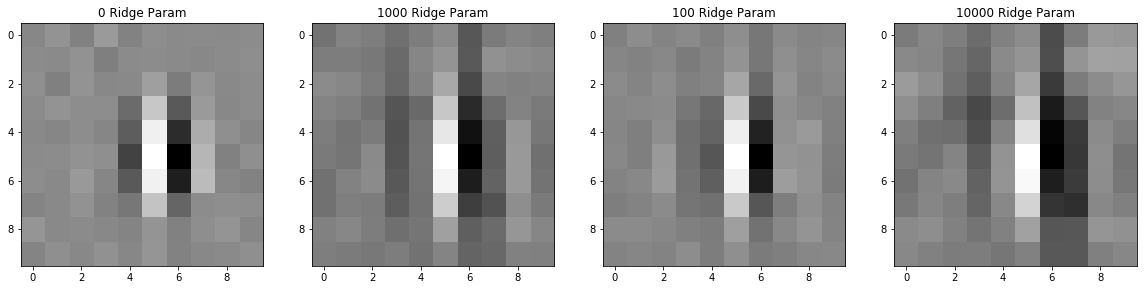

In [31]:
# Plot the different ridge solutions
n_plots = len(lvalues)
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for ax, (key, val) in zip(axs, out_filters_ridge.items()):
    ax.imshow(val.reshape([10, 10]), cmap='Greys_r')
    ax.set(title='{} Ridge Param'.format(key))

## Play around with other values of SNR and smaller amounts of data.